# Building a Movie Recommender using the Movie Lens Dataset

**In this project, we will explore two types of recommender systems: 1) collaborative filtering, and 2) content-based filtering. We will build our own recommendation system using the [MovieLens](https://movielens.org/home) dataset in Python.**

### What is MovieLens?

MovieLens is a recommender system that was developed by GroupLens, a computer science research lab at the University of Minnesota. It recommends movies to its users based on their movie ratings. It is also a dataset that is widely used in research and teaching contexts.

**This project is based on the following tutorial from Jill Cates (Data Scientist, Shopify). [tutorial link](https://www.youtube.com/watch?v=XfAe-HLysOM)**

**Project outline - This recommender build is broken down into 7 steps**

1. Import Libraries.
2. Load the data.
3. Exploratory data analysis.
4. Data pre-processing.
5. Collaborative filtering using K-Nearest Neighbors.
6. Handling the cold start problem with content-based filtering
7. Dimensionality reduction with matrix factorization

1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2.Load the Data

Below are the links to the data source.

In [107]:
ratings = pd.read_csv("data/ratings.csv")

In [108]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv("data/movies.csv")

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


3. Exploratory data analysis

In [111]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()
print(f"Number of ratings {n_ratings}")
print(f"Number of unique movieIds {n_movies}")
print(f"Number of unique users {n_users}")

Number of ratings 100836
Number of unique movieIds 9724
Number of unique users 610


Distribution of movie ratings

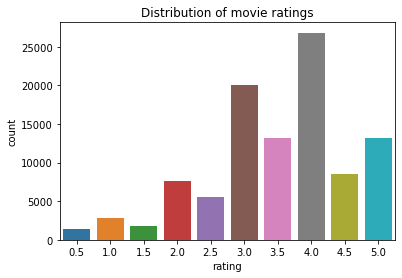

In [112]:
sns.countplot(x='rating',data=ratings)
plt.title("Distribution of movie ratings")
plt.show()

In [87]:
#mean rating
print(round(ratings['rating'].mean(),2))

3.5


In [88]:
#mean rating per use
ratings_groupby = round(ratings.groupby(by='userId')['rating'].mean(),2)
ratings_groupby_mean = round(ratings_groupby.mean(),2)
print(ratings_groupby_mean)

3.66


Most frequently rated movies

In [89]:
movie_ratings = ratings.merge(movies,on='movieId')
movie_ratings['title'].value_counts()

Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Sex, Drugs & Taxation (2013)          1
Extraordinary Tales (2015)            1
Tomorrow (2015)                       1
Embrace of the Serpent (2016)         1
31 (2016)                             1
Name: title, Length: 9719, dtype: int64

Lowest rated movie

In [11]:
movies_ratings_groupby = ratings.groupby(by='movieId')[['rating']].mean()
lowest_rated = movies_ratings_groupby['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


Lowest Rated Movie is "Gypsy"

Highest rated movie

In [12]:
highest_rated = movies_ratings_groupby['rating'].idxmax()
movies[movies['movieId']==highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Highest Rated Movie is "Lamerica"

In [13]:
movie_ratings[movie_ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp,title,genres
86227,85,53,5.0,889468268,Lamerica (1994),Adventure|Drama
86228,603,53,5.0,963180003,Lamerica (1994),Adventure|Drama


**Bayesian Average**

Bayesian Average is defined as:

$r_{i} = \frac{Cxm +\sum{reviews}}{C+N}$

Where C represents our confidence, m represents our prior, and N is the total number of reviews for a movie

C represents the typical dataset size, In this case, C will be the average number of ratings for a given movie.\
m represents the average rating across all movies

In [14]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count','mean'])

In [15]:
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [16]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie is {C}")
print(f"Average rating across all movies is {m}")

def bayesian_average(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg,2)

Average number of ratings for a given movie is 10.369806663924312
Average rating across all movies is 3.2624482748109656


In [17]:
#test bayesian average on Lamerica

Lamerica = pd.Series([5,5])
Lamerica_bayesian_avg = bayesian_average(Lamerica)
print(f"Lamerica bayesian avg is {Lamerica_bayesian_avg}")

Lamerica bayesian avg is 3.54


`Lamerica's` average Bayesian rating is 3.5\
Let's now apply Bayesian_Avg to all movies in our dataset

In [18]:
baysian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_average).reset_index()
baysian_avg_ratings.columns = ['movieId','bayesian_avg']

In [19]:
movie_stats_bayes = movie_stats.merge(baysian_avg_ratings, on = 'movieId')

In [20]:
movie_title_bayes = movies.merge(baysian_avg_ratings, on = 'movieId')

In [21]:
movie_title_bayes.sort_values(by='bayesian_avg',ascending=False)

,movieId,title,genres,bayesian_avg
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.39
659,858,"Godfather, The (1972)",Crime|Drama,4.24
2224,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.23
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.19
921,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.19
...,...,...,...,...
1988,2643,Superman IV: The Quest for Peace (1987),Action|Adventure|Sci-Fi,2.31
1144,1499,Anaconda (1997),Action|Adventure|Thriller,2.30
1372,1882,Godzilla (1998),Action|Sci-Fi|Thriller,2.27
2679,3593,Battlefield Earth (2000),Action|Sci-Fi,2.22


According to the bayesian average movies like `The Shawshank Redemption`, `The Godfather`, and `Fight Club` are the most popular movies.

In [22]:
movie_title_bayes.sort_values(by='bayesian_avg',ascending=True)

,movieId,title,genres,bayesian_avg
1172,1556,Speed 2: Cruise Control (1997),Action|Romance|Thriller,2.19
2679,3593,Battlefield Earth (2000),Action|Sci-Fi,2.22
1372,1882,Godzilla (1998),Action|Sci-Fi|Thriller,2.27
1144,1499,Anaconda (1997),Action|Adventure|Thriller,2.30
1988,2643,Superman IV: The Quest for Peace (1987),Action|Adventure|Sci-Fi,2.31
...,...,...,...,...
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.19
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.19
2224,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.23
659,858,"Godfather, The (1972)",Crime|Drama,4.24


According to the bayesian average, movies like `Speed 2` and `Battlefield Earth` are the worst rated movies.

**Cleaning the Movies dataset for genre and year**

The movies data needs to be cleaned in two ways.

Genre is expressed as a string with a pipe separating each genre. We will manipulate this string into a list.\

Title currently has year appended at the end. We will extract year from each title string and create a new column for it.

In [23]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
movies['genres'] = movies['genres'].apply(lambda x:x.split('|'))

In [25]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [26]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres in this dataset")

genre_frequency

There are 20 genres in this dataset


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

The most popular genres are Adventure, Animation, Children, Comedy, and Fantasy

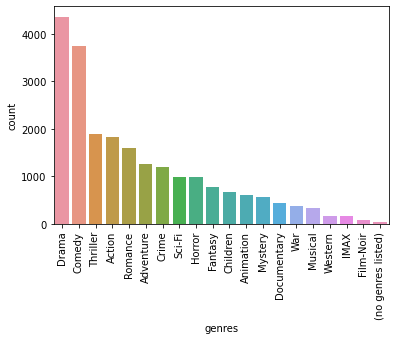

In [27]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genres','count']
sns.barplot(data=genre_frequency_df.sort_values(by='count',ascending=False),x = 'genres', y='count')
plt.xticks(rotation = 90)
plt.show()

**4. Data Preprocessing**

We are going to use collaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix. In this matrix, rows represent users and columns represent movies. Collaborative filtering is solely based on the movie recommendation of each user.

<img src="images/collaborative_filtering.png" width=50%/>

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id

$\bullet$ **user_mapper:** maps user id to user index\
$\bullet$ **movie_mapper:** maps movie id to movie index\
$\bullet$ **user_inv_mapper:** maps user index to user id\
$\bullet$ **movie_inv_mapper:** maps movie index to movie id\

Our $X$ (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely

In [28]:
from scipy.sparse import csr_matrix

def create_X(df):
    
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    
    user_mapper = dict(zip(np.unique(df['userId']),list(range(M))))
    movie_mapper = dict(zip(np.unique(df['movieId']),list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)),np.unique(df['userId'])))
    movie_inv_mapper = dict(zip(list(range(N)),np.unique(df['movieId'])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]
    
    X = csr_matrix((df['rating'], (user_index,item_index)), shape = (M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [29]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [30]:
X.shape

(610, 9724)

Our X Matrix contains 610 users and 9724 movies

**Evaluating sparsity**

Here we calcualte sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [31]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix Sparsity {round(sparsity*100,2)}")

Matrix Sparsity 1.7


In [32]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [33]:
print(f"Most active user rated {n_ratings_per_user.max()} movies")
print(f"Least active user rated {n_ratings_per_user.min()} movies")

Most active user rated 2698 movies
Least active user rated 20 movies


In [34]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [35]:
print(f"Movie with most ratings {n_ratings_per_movie.max()} ratings")
print(f"Movie with most ratings {n_ratings_per_movie.min()} ratings")

Movie with most ratings 329 ratings
Movie with most ratings 1 ratings


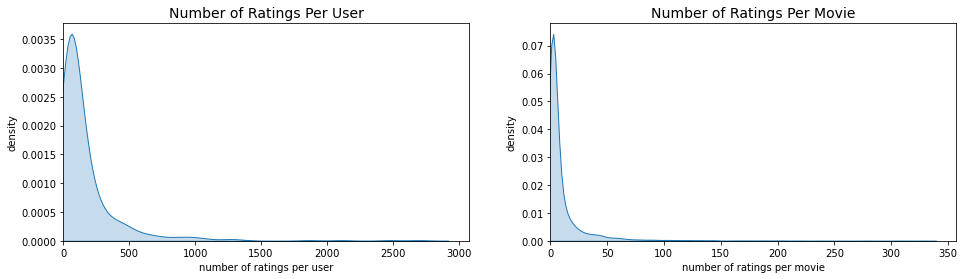

In [36]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

**Step 5: Item-Item Recommendations with K-Nearest Neighbors**

We are going to find the $k$ movies that have the most similar use engagement vectors for movie $i$

In [37]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    
    """
    Finds k-nearest neighbors for a given movie id.
    
    Args: 
    
    movie_id: id of the movie of interest
    X: user-item utility matrix
    k: number of similar movies to retrieve.
    metric: distance metric for KNN calculations
    
    Output: returns list of k similar movie IDs
    
    """
    
    X = X.T
    
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    
    if isinstance(movie_vec,(np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
        
    #use K+1 since KNN output includes the movieID of interest
    
    kNN = NearestNeighbors(n_neighbors = k+1, algorithm = "brute", metric = metric)
    
    kNN.fit(X)
    
    neighbor = kNN.kneighbors(movie_vec, return_distance=False)
    
    for i in range(0,k):
        
        n = neighbor.item(i)
        
        neighbour_ids.append(movie_inv_mapper[n])
        
    neighbour_ids.pop(0)
    
    return neighbour_ids

`find_similar_movies()` takes in a `movie id`and X matrix and outputs a list of $k$ movies that are similar to the movieid of interest

Below is how it works.

In [38]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, 10)

In [39]:
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

find_similar_movies() returns a list of movie_ids that are most similar to your movie of interest.
We will make a dictionary mapping the ids into titles.

In [40]:
movie_titles = dict(zip(movies['movieId'],movies['title']))

movie_id = 1

similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, 10)

movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")

for i in similar_movies:
    print(f"Watch {movie_titles[i]}")

Because you watched Toy Story (1995)
Watch Toy Story 2 (1999)
Watch Jurassic Park (1993)
Watch Independence Day (a.k.a. ID4) (1996)
Watch Star Wars: Episode IV - A New Hope (1977)
Watch Forrest Gump (1994)
Watch Lion King, The (1994)
Watch Star Wars: Episode VI - Return of the Jedi (1983)
Watch Mission: Impossible (1996)
Watch Groundhog Day (1993)


The results above show the 10 movies that are most similar to Toy Story. The recommendation system seems to be working well as it has recommended family friendly movies from the 90s. These recommendations are based solely on user-item ratings.

Below are recommended movies using euclidean distance

In [41]:
movie_id = 1

similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, 10, metric = 'euclidean')

movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")

for i in similar_movies:
    print(f"Watch {movie_titles[i]}")

Because you watched Toy Story (1995)
Watch Toy Story 2 (1999)
Watch Mission: Impossible (1996)
Watch Independence Day (a.k.a. ID4) (1996)
Watch Bug's Life, A (1998)
Watch Nutty Professor, The (1996)
Watch Willy Wonka & the Chocolate Factory (1971)
Watch Babe (1995)
Watch Groundhog Day (1993)
Watch Mask, The (1994)


**Step 6: Handling the cold-start problem**

Collaborative filtering relies solely on user-item interactions within the utility matrix.

The problem with this model is that brand new users or items with no interactions get excluded from the recommendation system.

This is called the cold start problem.

Content based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe and will be populated with 0 or 1.

In [42]:
n_movies = movies["movieId"].nunique()
print(f"There are {n_movies} unique movies in our movies dataset")

There are 9742 unique movies in our movies dataset


In [43]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [44]:
genres = set(g for G in movies['genres'] for g in G)
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [45]:
one_hot_encoded_df = []
for rows in movies['genres']:
    one_hot_encoded = [int(1) if genre in rows else int(0) for genre in genres]
    one_hot_encoded_df.append(one_hot_encoded)

In [46]:
genre_one_hot = pd.DataFrame(data=one_hot_encoded_df, index=None, columns=genres, dtype=None, copy=None)

In [47]:
genre_one_hot

,Children,Crime,Action,Animation,Film-Noir,Fantasy,Sci-Fi,(no genres listed),Thriller,War,Western,Mystery,Comedy,Horror,Musical,IMAX,Drama,Documentary,Adventure,Romance
0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9740,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
movies = pd.concat([movies, genre_one_hot], axis=1)

In [49]:
movies

,movieId,title,genres,Children,Crime,Action,Animation,Film-Noir,Fantasy,Sci-Fi,...,Western,Mystery,Comedy,Horror,Musical,IMAX,Drama,Documentary,Adventure,Romance
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",0,0,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
9739,193585,Flint (2017),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
movie_genres = genre_one_hot

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres,movie_genres)

print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


As expected, after passing the `movie_genres` dataframe into the cosine_similarity() function.

we get a cosine similarity matrix of shape ($n_{movies}$,$n_{movies}$)

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axis.

**Creating a movie finder function**

Let's say we want to get recommendations for movies that are similar to Toy Story. To get results from our recommender, we need to know the exact title of a movie in our dataset.

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in. Let's create a function called `movie_finder()` which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

In [113]:
cosine_sim[0]

array([1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
       0.4472136 ])

Instead of using the mapper, we will use a function called fuzzy wuzzy to match movie id to title.

In [114]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

Testing this out with Toy Story

In [56]:
movie_title = movie_finder('Tiy Story')

In [65]:
movie_title

'Toy Story (1995)'

To get recommendations for `Toy Story` with the cosine similarity score, we need to find its index in the cosine similarity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Below, creating a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices.

In [68]:
movie_idx = dict(zip(movies['title'],list(movies.index)))
idx = movie_idx[movie_title]
print(f"movie index for Toy Story {idx}")

movie index for Toy Story 0


using movie idx we know that `Toy Story` is represented by 0 in the matrix. We can now find the top 10 movies similar to Toy Story using content filtering.

In [79]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:n_recommendations+1]

In [80]:
sim_scores

[(1706, 0.9999999999999999),
 (2355, 0.9999999999999999),
 (2809, 0.9999999999999999),
 (3000, 0.9999999999999999),
 (3568, 0.9999999999999999),
 (6194, 0.9999999999999999),
 (6486, 0.9999999999999999),
 (6948, 0.9999999999999999),
 (7760, 0.9999999999999999),
 (8219, 0.9999999999999999)]

In [81]:
similar_movies = [i[0] for i in sim_scores]

In [82]:
similar_movies

[1706, 2355, 2809, 3000, 3568, 6194, 6486, 6948, 7760, 8219]

`similar movies` is an array of indices that represent Toy Story's top 10 recommendations. We can get the corresponding movie titles by using iloc on the 'title' column of the 'movie' dataframe

In [115]:
print(f"Because you watched {movie_title}")
movies["title"].iloc[similar_movies]

Because you watched Toy Story (1995)


586     Haunted World of Edward D. Wood Jr., The (1996)
480                            Terminal Velocity (1994)
588                        Great White Hype, The (1996)
1073                               Jerry Maguire (1996)
1270                  I Love You, I Love You Not (1996)
356                        Age of Innocence, The (1993)
1265                               Sliding Doors (1998)
260                                    Quiz Show (1994)
1197                       In the Company of Men (1997)
Name: title, dtype: object

The recommendation system seems to be working as the movies recommended are family friendly animation films.

Below is the code for a single function to recommend movies.

In [94]:
def get_content_based_recommendation(title_string, n_recommendations):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_recommendations+1]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {movie_title}")
    print(movies["title"].iloc[similar_movies])

In [95]:
get_content_based_recommendation("jumanji", n_recommendations)

Because you watched Toy Story (1995)
53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object


**Step 7: Dimensionality Reduction with Matrix Factorization**

Matrix Factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two-factor matrices.\

**-user factor matrix(n_users,k)**\
**-item factor matrix(k, n_items)**\
\
We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each\
latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 90s, while another latent feature may represent movies which are independent foreign language films.


$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X}$$

<img src="images/matrix_factorization.png" width="50%"/>

In [96]:
from sklearn.decomposition import TruncatedSVD

In [97]:
svd = TruncatedSVD(n_components=20,n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [100]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, k=10, metric='cosine')
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)


### Conclusion

Both the collaborative filtering and content filtering models were decent at recommending 10 most similar movies of a single movie. However, a drawback of this model and data is that there is no concrete way to measure evaluation metrics. If this was used in the real world, a good way to measure the effectiveness of this model would be to do an A/B test to see if the model was effective in increasing user viewing time or user engagement. However, due to the limitations of this project, it was not possible to do such a test.